In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from IPython.display import HTML,display
import PIL 
from PIL import Image
import os
import glob
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
import torchvision
import torchvision.transforms as transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2

import os
import cv2
import nibabel as nib
from PIL import Imag

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as 

In [290]:
class AortaDataset():
    def __init__(self, images_list, masks_list, transform=None):
        self.images = images_list
        self.masks = masks_list
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.images[idx]
        mask_path = self.masks[idx]
        
        image = Image.open(image_path).convert("L")
        mask = Image.open(mask_path).convert("L")
        # Convert PIL Image to numpy array
        image = np.array(image)
        # Add channel dimension (making it 1 x height x width)
        image = np.expand_dims(image, axis=0)
        # Convert numpy arrays to PyTorch tensors
        image = torch.from_numpy(image).float()
        
        mask = np.array(mask)
        mask = (mask > 127.5).astype(np.float32)  # Binarizing the mask
        mask = np.expand_dims(mask, axis=0)
        mask = torch.from_numpy(mask).float()


        if self.transform:
            image = self.transform(image)
        return image, mask, image_path, mask_path

In [291]:
modified_image_dir  = "/Users/owner/Desktop/AI NYU Langone/Train/Images/"
modified_mask_dir  = "/Users/owner/Desktop/AI NYU Langone/Train/Masks_png/"

# Lists of modified image and mask paths
modified_image_data_path_list = sorted([os.path.join(modified_image_dir, f) for f in os.listdir(modified_image_dir) if f.endswith('.tif')])
modified_mask_data_path_list = sorted([os.path.join(modified_mask_dir, f) for f in os.listdir(modified_mask_dir) if f.endswith('.png')])

dataset = AortaDataset(images_list = modified_image_data_path_list, masks_list= modified_mask_data_path_list)

In [292]:
def visualize_tensor(tensor, title=""):
    plt.imshow(tensor.cpu().detach().numpy(), cmap='gray')
    plt.title(title)
    plt.show()

class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)
        self.relu = nn.ReLU()
    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        return x

class decoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        self.conv = conv_block(out_c + out_c, out_c)
    
    def forward(self, inputs, skip):
        x = self.up(inputs)
        
        # Crop the skip tensor to match upsampled tensor's size
        _, _, h, w = x.shape
        skip = skip[:, :, :h, :w]
        
        x = torch.cat([x, skip], axis=1)
        x = self.conv(x)
        return x

class encoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv = conv_block(in_c, out_c)
        self.pool = nn.MaxPool2d((2, 2))
    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)
        return x, p
    
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # Encoder
        self.e1 = encoder_block(1, 64)   # Assuming grayscale input
        self.e2 = encoder_block(64, 128)
        self.e3 = encoder_block(128, 256)
        self.e4 = encoder_block(256, 512)
        
        # Bridge
        self.b = conv_block(512, 1024)
        
        # Decoder
        self.d1 = decoder_block(1024, 512)
        self.d2 = decoder_block(512, 256)
        self.d3 = decoder_block(256, 128)
        self.d4 = decoder_block(128, 64)
        
        # Final Output
        self.outputs = nn.Conv2d(64, 1, kernel_size=1, padding=0)
        
    def forward(self, inputs):
        s1, p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)
        
        b = self.b(p4)
        
        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)
        
        outputs = self.outputs(d4)
        return outputs

torch.Size([1, 45, 150])
torch.Size([1, 45, 150])


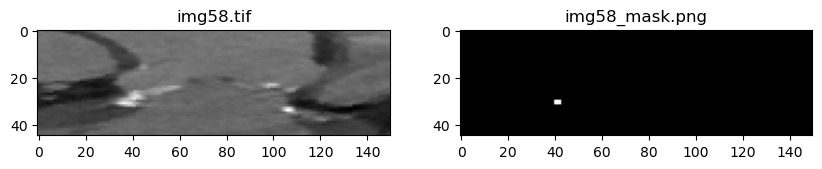

In [293]:
image, mask, image_path, mask_path = dataset[40]
print(mask.shape)
print(image.shape)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(image.squeeze(), cmap = "gray")
ax[0].set_title(os.path.basename(image_path))
ax[1].imshow(mask.squeeze(), cmap = "gray")
ax[1].set_title(os.path.basename(mask_path))
plt.show()

In [297]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Create an instance of the UNet model
model = UNet()
model = model.to(device)  # Move model to GPU if available

# Define the loss function and optimizer
criterion = nn.BCEWithLogitsLoss()  # Binary cross entropy with logits is commonly used for binary segmentation tasks
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Create data loaders for training (and optionally validation)
train_dataset = AortaDataset(images_list= modified_image_data_path_list, masks_list= modified_mask_data_path_list)  # You can also apply transformations if needed
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

In [ ]:
def dice_coefficient(predicted, target):
    # Flatten the tensors
    predicted = predicted.view(-1)
    target = target.view(-1)
    
    intersection = (predicted * target).sum()
    return (2. * intersection) / (predicted.sum() + target.sum())

In [309]:
num_epochs = 50
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    epoch_loss = 0
    epoch_dice = 0

    for batch in train_loader:
        images, masks, image_path, mask_path = batch
        images, masks = images.to(device), masks.to(device)  # Move data to GPU if available
        
        # Forward pass
        outputs = model(images)
        outputs = F.interpolate(outputs, size=(45, 150), mode='bilinear', align_corners=True)
        
        # Compute the loss
        loss = criterion(outputs, masks)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        # Calculate Dice Coefficient
        with torch.no_grad():
            predicted = torch.sigmoid(outputs)  # Apply sigmoid to get values between 0 and 1
            predicted = (predicted > 0.5).float()  # Binarize the output
            intersection = (predicted * masks).sum()
            dice_val = (2. * intersection) / (predicted.sum() + masks.sum())
            epoch_dice += dice_val.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(train_loader)}, Dice Coefficient: {epoch_dice/len(train_loader)}")

Epoch 1/50, Loss: 0.012149069458246231, Dice Coefficient: 0.7381725708643595
Epoch 2/50, Loss: 0.011936136210958162, Dice Coefficient: 0.721120278040568
Epoch 3/50, Loss: 0.011673522181808949, Dice Coefficient: 0.8112128178278605
Epoch 4/50, Loss: 0.011495834216475487, Dice Coefficient: 0.7478268345197042
Epoch 5/50, Loss: 0.011448996762434641, Dice Coefficient: 0.7713618477185568
Epoch 6/50, Loss: 0.0112054410080115, Dice Coefficient: 0.8045718868573507
Epoch 7/50, Loss: 0.01114557683467865, Dice Coefficient: 0.7288331389427185
Epoch 8/50, Loss: 0.010804679555197557, Dice Coefficient: 0.8252229889233907
Epoch 9/50, Loss: 0.010564370391269525, Dice Coefficient: 0.8194539348284403
Epoch 10/50, Loss: 0.010382339668770632, Dice Coefficient: 0.8320205012957255
Epoch 11/50, Loss: 0.010137134231626987, Dice Coefficient: 0.8354984720547994
Epoch 12/50, Loss: 0.0099124601110816, Dice Coefficient: 0.8583078384399414
Epoch 13/50, Loss: 0.009802514997621378, Dice Coefficient: 0.8555454015731812
E

In [9]:
from skimage.transform import resize

def overlay_grayscale_mask_on_image(image, mask, color=(255, 0, 0)):
    """
    Overlay the grayscale mask on the grayscale image.
    :param image: The original grayscale image.
    :param mask: The grayscale mask.
    :param color: RGB color for mask overlay. Default is red.
    :return: The image with mask overlaid.
    """
    
    mask_np = np.array(mask).squeeze()
    
    # Resize the mask to match the image dimensions
    mask_np = resize(mask_np, (45, 150))
    image_np = np.array(image).squeeze()
    # Normalize the image values to [0, 1] range
    image_np = (image_np - np.min(image_np)) / (np.max(image_np) - np.min(image_np))
    # Convert grayscale image to RGB
    image_rgb = np.stack([image_np]*3, axis=-1) * 255.0  # Scale to [0, 255]
    print("Max mask value:", mask_np.max())
    print("Min mask value:", mask_np.min())

    # Overlay the mask on each channel of the image
    for i in range(3):
        image_rgb[:,:,i] = np.where(mask_np > 0.1, color[i], image_rgb[:,:,i])
    
    return image_rgb

# Let's visualize an example
#overlay = overlay_grayscale_mask_on_image(image, mask)
#plt.imshow(overlay.astype(np.uint8))
#plt.axis('off')
#plt.show()

torch.Size([1, 1, 45, 150])
Max mask value: 4.271968
Min mask value: -10.720463


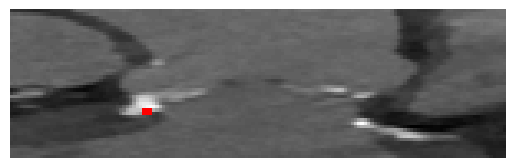

In [319]:
def preprocess_image(image_path):    
    # Load the image
    image = Image.open(image_path).convert("L")
    image = image.resize((150, 45), Image.ANTIALIAS)
    # Convert PIL Image to numpy array
    image = np.array(image)
     # Add channel dimension (making it 1 x height x width)
    image = np.expand_dims(image, axis=0)
    # Convert numpy arrays to PyTorch tensors
    image_tensor = torch.from_numpy(image).float()
    image_tensor = image_tensor.unsqueeze(1)
    print(image_tensor.shape)
    return image_tensor

def postprocess_output(output_tensor):
    return output_tensor.detach().numpy().squeeze()

# Process a new image
image_path = "/Users/owner/Desktop/AI NYU Langone/raw1_label/img19.tif"
image_tensor = preprocess_image(image_path)

# Pass the image through the U-Net
with torch.no_grad():
    mask = model(image_tensor)

# Convert the mask to numpy for visualization
mask_np = postprocess_output(mask)

# Overlay the mask on the original image
overlay = overlay_grayscale_mask_on_image(image_tensor.squeeze(), mask_np)

# Display the result
plt.imshow(overlay.astype(np.uint8))
plt.axis('off')
plt.show()